# Exploration of Data and Preprocessing

This dataset was taken from Kaggle: https://www.kaggle.com/datasets/datasnaek/mbti-type.
It includes over 8600 rows of data, with each row having a person's MBTI type and their top 50 posts.

**Exploring the Data:**

Before preprocessing the data, we first explore what it looks like, including the number of tweets per personality type and what the tweets actually look like.

In [1]:
import pandas as pd

data = pd.read_csv('data/mbti_1.csv')
data.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [2]:
# looks at general data information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


In [3]:
# counts number of tweets per MBTI type
data['type'].value_counts()

INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: type, dtype: int64

In [4]:
# look at some of the tweets directly
print("Type: {} \nPosts: {}".format(data.type[0], data.posts[0]))

Type: INFJ 
Posts: 'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.|||May the PerC Experience immerse you.|||The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206|||Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...|||84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/uploads/2010/04/round-h

There seem to be some tweets we need to parse out, including symbols and hyperlinks. We want to look at the words in these tweets, so the hyperlinks and symbols will not be factored into our classification.

## Preprocessing the data:

First, we clean the data. Because there are symbols, hyperlinks, and stopwords we would like to get rid of, we will start by taking out these words/phrases. 

In [5]:
from sklearn.model_selection import train_test_split

# split the data into training and test data: 80:20
train_data, test_data = train_test_split(data, test_size=.2)

In [6]:
import re
import string

# Helper function: get rid of |||, hyperlinks, symbols, parentheses, punctuation, etc.
def clean_data(data):
    cleaned_data = []

    for tweets in data.posts:
        # get rid of '|||' inbetween the tweets
        tweets = re.sub('[|||]+', '', tweets)
        # hyperlinks
        tweets = re.sub('https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)', '', tweets)
        # punctuation
        tweets = re.sub('['+re.escape(string.punctuation)+']', '', tweets)
        tweets = re.sub('[’‘“\.”…–]', '', tweets)
        # gets rid of brackets
        tweets = re.sub('(\[|\()*\d+(\]|\))*', '', tweets)
        # gets rid of large spaces
        tweets = re.sub(' +', ' ', tweets)

        cleaned_data.append(tweets.lower())

    return cleaned_data

In [7]:
# clean training and test data
train_data['cleaned_data'] = clean_data(train_data)
test_data['cleaned_data'] = clean_data(test_data)

<ipython-input-6-287669c37438>:10: FutureWarning: Possible set union at position 2
  tweets = re.sub('[|||]+', '', tweets)
<ipython-input-7-e9b2032802a0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['cleaned_data'] = clean_data(train_data)
<ipython-input-7-e9b2032802a0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['cleaned_data'] = clean_data(test_data)


After cleaning the data, we can see which types of words are most popular in each MBTI personality type's twitter tweets.

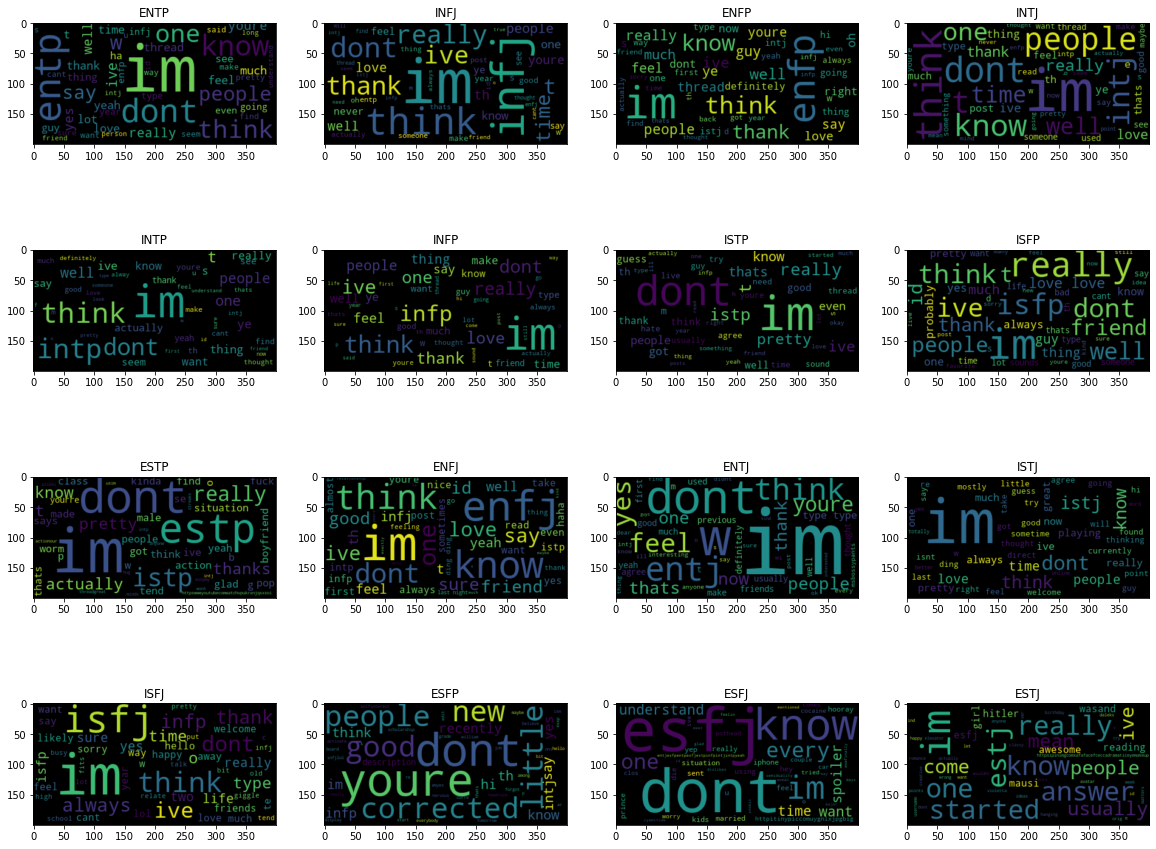

In [9]:
import matplotlib.pyplot as plt
import wordcloud
from wordcloud import WordCloud

def wordclouds(df):
    fig, ax = plt.subplots(len(df['type'].unique()), sharex=True, figsize=(20,len(df['type'].unique())))
    num = 0
    for type in df['type'].unique():
        df_4 = df[df['type'] == type]
        wordcloud = WordCloud(max_words=50, relative_scaling=1).generate(df_4['cleaned_data'].to_string())
        
        plt.subplot(4, 4, num + 1)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(type)
        ax[num].axis("off")
        num += 1

wordclouds(train_data)

Now, we lemmatize the data and use tf-idf weighting to see which words are weighted more heavily with each user.

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Download stopwords list
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

# create stopwords list
stop_words = set(stopwords.words('english')) 

# combine nltk with sklearn 
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(token) for token in word_tokenize(doc)]

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/emilynguyen/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/emilynguyen/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/emilynguyen/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/emilynguyen/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


In [11]:
# Lemmatize the stop words
tokenizer=LemmaTokenizer()
vectorizer = TfidfVectorizer(stop_words=tokenizer(' '.join(stop_words)), lowercase=True, tokenizer=tokenizer, max_features=10000)

In [12]:
vectorizer.fit(train_data.posts)
tfidf_train_posts=vectorizer.transform(train_data.posts).toarray()

/Users/emilynguyen/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [ ]:
train_tokens = vectorizer.get_feature_names()
tfidf_df_train = pd.DataFrame(data=tfidf_train_posts, index=train_data.type, columns=train_tokens)
tfidf_df_train

/Users/jmc/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,!,#,$,%,&,','','all,'are,'as,...,»,͜ʖ,͡°,–,—,‘,’,“,”,•
type,,,,,,,,,,,,,,,,,,,,,
INTP,0.108706,0.0,0.0,0.000000,0.000000,0.020045,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENFP,0.186452,0.0,0.0,0.000000,0.031342,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
INFP,0.168767,0.0,0.0,0.032398,0.000000,0.024568,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ISTJ,0.129528,0.0,0.0,0.013123,0.029031,0.013269,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENTP,0.000000,0.0,0.0,0.000000,0.000000,0.008013,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ESTP,0.000000,0.0,0.0,0.000000,0.000000,0.015054,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENTP,0.043061,0.0,0.0,0.011219,0.000000,0.011343,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ISTJ,0.016441,0.0,0.0,0.000000,0.000000,0.022737,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
vectorizer.fit(test_data.posts)
tfidf_test_posts=vectorizer.transform(test_data.posts).toarray()

/Users/jmc/opt/miniconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
test_tokens = vectorizer.get_feature_names()
tfidf_df_test = pd.DataFrame(data=tfidf_test_posts, index=test_data.type, columns=test_tokens)
tfidf_df_test

/Users/jmc/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,!,#,$,%,&,','','-,'as,'at,...,͡°,–,—,―,‘,’,“,”,ツ,💎g3m
type,,,,,,,,,,,,,,,,,,,,,
INFJ,0.114543,0.000000,0.0,0.000000,0.118874,0.013074,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0
INTP,0.120228,0.019023,0.0,0.000000,0.000000,0.006099,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0
INFJ,0.000000,0.000000,0.0,0.000000,0.000000,0.043798,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0
INFP,0.094930,0.000000,0.0,0.014235,0.016420,0.021671,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.026291,0.0,0.0,0.0,0.0
INFJ,0.028807,0.000000,0.0,0.000000,0.000000,0.070145,0.0,0.228625,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ISTJ,0.013999,0.000000,0.0,0.000000,0.000000,0.025565,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0
INFP,0.098543,0.000000,0.0,0.000000,0.000000,0.007498,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0
INFJ,0.000000,0.000000,0.0,0.000000,0.000000,0.015486,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0


Save the preprocessed, normalized data into a csv file:

In [ ]:
# training data
compression_opts = dict(method='zip', archive_name='tfidf_train_data.csv')  
tfidf_df_train.to_csv('data/tfidf_train_data.zip', compression=compression_opts)

In [ ]:
# test data
compression_opts = dict(method='zip', archive_name='tfidf_test_data.csv')  
tfidf_df_test.to_csv('data/tfidf_test_data.zip', compression=compression_opts)